# Linear Regression

In [2]:
from statsbombpy import sb
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import seaborn as sns
import json
import numpy as np
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, Standardizer, FontManager

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
minutes_played=np.array([120,452,185,708,340,561])
goals_scored=np.array([1,6,3,7,3,5])

In [4]:
#Set up dataframe
minutes_played=np.array([120,452,185,708,340,561])
goals_scored=np.array([1,6,3,7,3,5])

In [10]:
#Set up dataframe
minutes_model = pd.DataFrame()
minutes_model = minutes_model.assign(minutes=minutes_played)
minutes_model = minutes_model.assign(goals=goals_scored)

(0.0, 8.0)

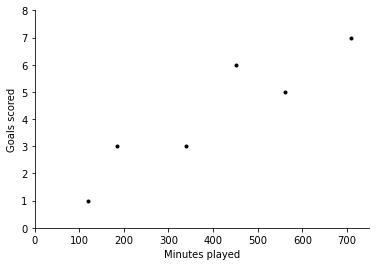

In [8]:
fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Goals scored')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8))

In [9]:
#Slope of one goal per 90 played
#b=1/90
#Intercept
a=0

In [11]:
model_fit=smf.ols(formula='goals_scored ~ minutes_played -1 ', data=minutes_model).fit()

In [24]:
print(model_fit.summary()) 
[b]=model_fit.params

                                 OLS Regression Results                                
Dep. Variable:           goals_scored   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              156.1
Date:                Wed, 24 Jan 2024   Prob (F-statistic):                    5.83e-05
Time:                        13:15:07   Log-Likelihood:                         -7.2998
No. Observations:                   6   AIC:                                      16.60
Df Residuals:                       5   BIC:                                      16.39
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

c:\Users\34626\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [15]:
x=np.arange(800,step=0.1)
y= a + b*x 

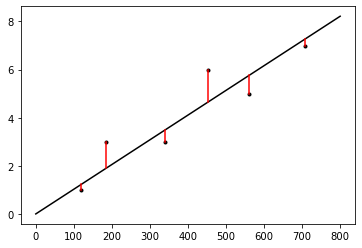

In [21]:
fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', color='black')
ax.plot(x, y, color='black')

#Show distances to line
for i,mp in enumerate(minutes_played):
    ax.plot([mp,mp],[goals_scored[i],a+b*mp], color='red')


plt.show()

 # xG Model Fit

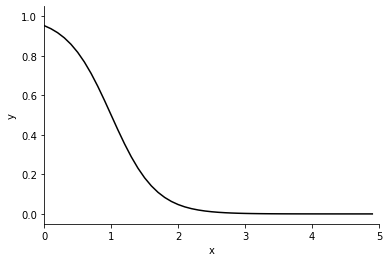

In [25]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(-b[0]-b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [28]:
with open(r'C:\Users\34626\OneDrive\Documents\Jaume\Big Data\Football\events/events_Spain.json') as f:
    data = json.load(f)

#Create a data set of shots.
train = pd.DataFrame(data)
pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot' ]
shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y'])

In [33]:
for i, shot in shots.iterrows():

    header=0
    for shottags in shot['tags']:
        if shottags['id'] == 403:
            header=1
    #Only include non-headers          
    if not(header):
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50) #Get the position relative to the center of the Y-axis

        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*120/100
        y=shots_model.at[i,'C']*80/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))

        if a<0:
            a=np.pi+a
        shots_model.at[i, 'Angle'] = a

        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

In [31]:
#Get first 200 shots
shots_200=shots_model.iloc[:200]

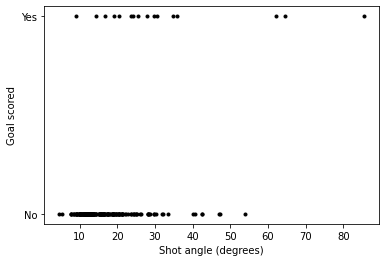

In [35]:
#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

C:\Users\34626\AppData\Local\Temp\ipykernel_10632\3664498083.py:5: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


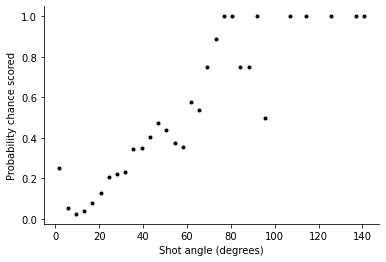

In [40]:
goals_only = shots_model[shots_model['Goal']== 1]
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0]) #Probability is the num_goals/total_shots
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

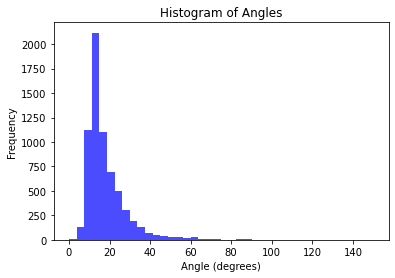

In [44]:
# Unpack the histogram values and bin edges
counts, bin_edges = shotcount_dist

# Calculate bin centers from bin edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], color='blue', alpha=0.7)

# Set plot labels and title
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Angles')

# Show the plot
plt.show()

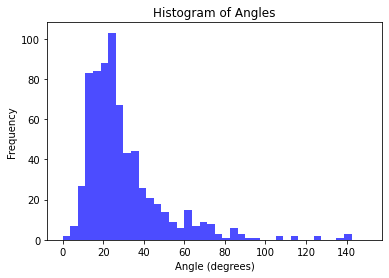

In [45]:
# Unpack the histogram values and bin edges
counts, bin_edges = goalcount_dist

# Calculate bin centers from bin edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], color='blue', alpha=0.7)

# Set plot labels and title
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Angles')

# Show the plot
plt.show()

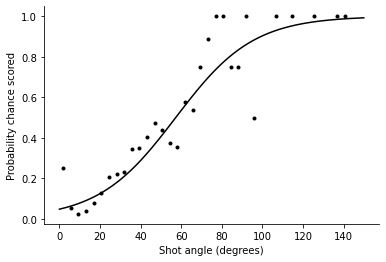

In [49]:
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')
plt.show()


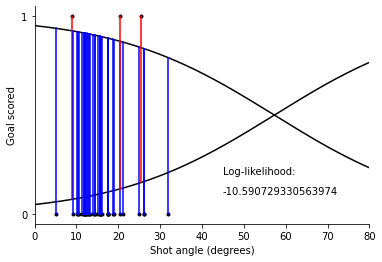

In [51]:
#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)  
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6606
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1920.3
Date:                    Wed, 24 Jan 2024   Deviance:                       3840.6
Time:                            13:44:22   Pearson chi2:                 6.16e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.09382
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

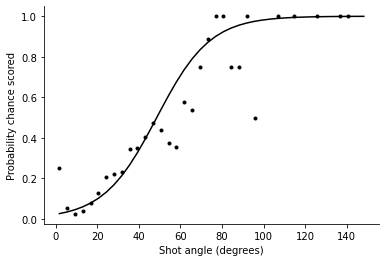

In [54]:
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params #bo is Angle coef, and b1 is Intercept coef


xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6606
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1885.1
Date:                    Wed, 24 Jan 2024   Deviance:                       3770.3
Time:                            15:54:06   Pearson chi2:                 2.87e+07
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1034
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

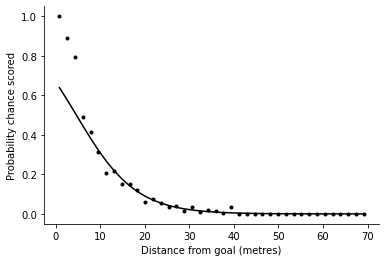

In [55]:
#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6605
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1861.3
Date:                    Wed, 24 Jan 2024   Deviance:                       3722.7
Time:                            15:55:28   Pearson chi2:                 6.71e+03
No. Iterations:                         6   Pseudo R-squ. (CS):             0.1098
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

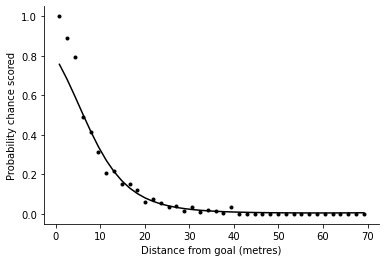

In [56]:
#Adding distance squared
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

In [57]:
#Adding even more variables to the model.
squaredX = shots_model['X']**2
shots_model = shots_model.assign(X2=squaredX)
squaredC = shots_model['C']**2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model['Angle']*shots_model['X']
shots_model = shots_model.assign(AX=AX)

In [97]:
# A general model for fitting goal probability
# List the model variables you want here
#model_variables = ['Angle','Distance','X','C']
model_variables = ['Distance', 'C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6605
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1871.2
Date:                    Wed, 24 Jan 2024   Deviance:                       3742.5
Time:                            16:19:47   Pearson chi2:                 3.44e+06
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1072
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [98]:
#Return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)


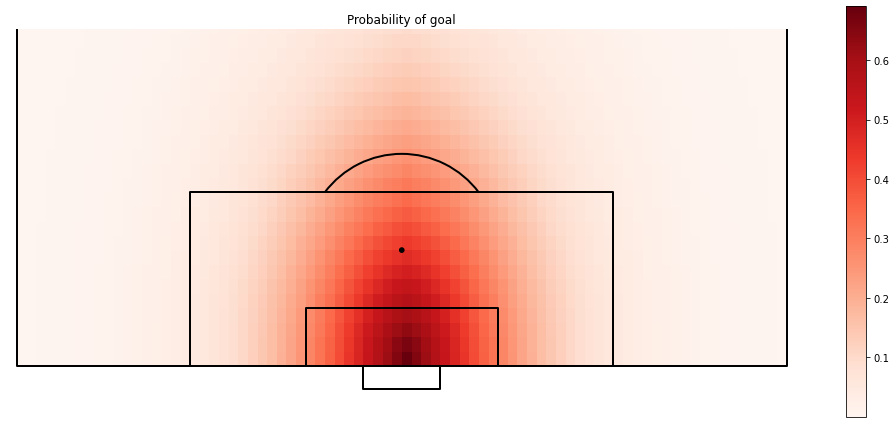

In [99]:
#Create a 2D map of xG
pgoal_2d=np.zeros((80,80))
for x in range(80):
    for y in range(80):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-80/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-80/2)**2)
        sh['D2'] = x**2 + abs(y-80/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-80/2)
        sh['C2'] = (y-80/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

#Plot the xG from each position 
pitch = VerticalPitch(pitch_type='statsbomb', half=False, goal_type= 'box', line_color='black') 
fig, ax = pitch.draw(figsize=(14, 6))
pos=ax.imshow(pgoal_2d, extent=[0,80,120, 0], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((-1,81))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [100]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots_model, 
                           family=sm.families.Binomial()).fit()
1-test_model.llf/null_model.llf

#ROC curve
numobs=100
TP=np.zeros(numobs)
FP=np.zeros(numobs)
TN=np.zeros(numobs)
FN=np.zeros(numobs)

In [101]:
for i,threshold in enumerate(np.arange(0,1,1/numobs)):
    for j,shot in shots_model.iterrows():
        if (shot['Goal']==1): 
            if(shot['xG']>threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal']==0): 
            if(shot['xG']>threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

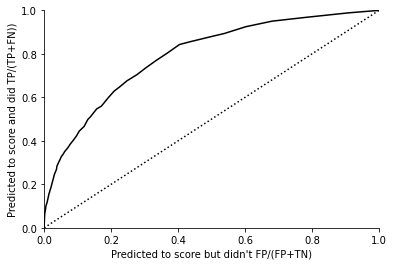

In [103]:
fig,ax=plt.subplots(num=1)
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0,1], [0,1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)           